## Практическое задание к уроку № 4 по теме "Uplift-моделирование".

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. провести uplift-моделирование 3 способами:
    1. одна модель с признаком коммуникации (S-learner)
    2. модель с трансформацией таргета
    3. вариант с двумя независимыми моделями
5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей
6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

#### Задание 1.

In [1]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.models import ClassTransformation, SoloModel, TwoModels

In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df.shape

(64000, 9)

In [4]:
df.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
offer             object
conversion         int64
dtype: object

#### Задание 2.

In [5]:
df.rename({'conversion': 'target', 'offer': 'treatment'}, axis=1, inplace=True)

In [6]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [7]:
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df['treatment'] = df['treatment'].astype('int')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [8]:
df['target'].value_counts(normalize=True)

0    0.853219
1    0.146781
Name: target, dtype: float64

In [9]:
df.groupby('treatment')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


Имеется дисбаланс значений целевой переменной и  
дисбаланс размеров экспериментальной и контрольной  
групп.

#### Задание 3.

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['target'], random_state=29)

In [11]:
X_train = df_train.drop(['treatment', 'target'], axis=1)
y_train = df_train['target']
treat_train = df_train['treatment']

X_test = df_test.drop(['treatment', 'target'], axis=1)
y_test = df_test['target']
treat_test = df_test['treatment']

#### Задание 4.

In [12]:
cat_features = ['channel', 'zip_code']

Одна модель:

In [13]:
sm = SoloModel(
    CatBoostClassifier(iterations=100, random_state=29, cat_features=cat_features, silent=True)
)

sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

In [14]:
sm_score_10, sm_score_20

(0.0990015110808514, 0.07884371845462051)

Модель с трансформацией:

In [15]:
ct = ClassTransformation(
    CatBoostClassifier(iterations=100, random_state=29, cat_features=cat_features, silent=True)
)

ct = ct.fit(X_train, y_train, treat_train)
uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

In [16]:
ct_score_10, ct_score_20

(0.07782311292451696, 0.07682940258786822)

Две независимые модели:

In [17]:
tm = TwoModels(
    CatBoostClassifier(iterations=100, random_state=29, cat_features=cat_features, silent=True),
    CatBoostClassifier(iterations=100, random_state=29, cat_features=cat_features, silent=True),
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)
uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

In [18]:
tm_score_10, tm_score_20

(0.09357068160277432, 0.10078737267137744)

#### Задание 5.

Сведём метрики моделей в таблицу:

In [19]:
models = np.array(['SoloModel', 'ClassTransformation', 'Two independent'])
columns = ['Uplift@10%', 'Uplift@20%']
data = np.array([
    [sm_score_10, sm_score_20],
    [ct_score_10, ct_score_20],
    [tm_score_10, tm_score_20]
])
pd.DataFrame(data, index=models, columns=columns).sort_values('Uplift@20%', ascending=False)

,Uplift@10%,Uplift@20%
Two independent,0.093571,0.100787
SoloModel,0.099002,0.078844
ClassTransformation,0.077823,0.076829


Лучшей оказалась метрика двух независимых моделей.  
Был выбран способ расчёта метрики *by_group*, так как  
имеется дисбаланс размеров экспериментальной и контрольной  
групп.

#### Задание 6.

Построим зависимость конверсии от предсказанного значения uplift для алгоритма  
с одной моделью:

In [20]:
new_uplift_sm = pd.Series(uplift_sm, name='uplift_sm', index=X_test.index)

In [21]:
new_df = pd.concat((X_test, new_uplift_sm, y_test), axis=1).sort_values('uplift_sm', ascending=False).reset_index(drop=True)
new_df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift_sm,target
0,12,946.14,1,1,Surburban,1,Phone,0.238391,1
1,10,859.98,1,1,Surburban,1,Phone,0.203023,0
2,10,832.11,1,1,Surburban,1,Phone,0.202335,0
3,10,977.80,1,1,Surburban,1,Phone,0.195916,1
4,3,732.34,1,1,Rural,1,Phone,0.195183,0


In [22]:
deciles = pd.Series(pd.qcut(new_df.index, 10, labels=[f'decile_{i}' for i in range(1, 11)]), name='decile')

In [23]:
new_df = pd.concat((new_df, deciles), axis=1)
new_df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift_sm,target,decile
0,12,946.14,1,1,Surburban,1,Phone,0.238391,1,decile_1
1,10,859.98,1,1,Surburban,1,Phone,0.203023,0,decile_1
2,10,832.11,1,1,Surburban,1,Phone,0.202335,0,decile_1
3,10,977.80,1,1,Surburban,1,Phone,0.195916,1,decile_1
4,3,732.34,1,1,Rural,1,Phone,0.195183,0,decile_1
...,...,...,...,...,...,...,...,...,...,...
19195,3,399.26,1,1,Rural,0,Web,-0.057836,1,decile_10
19196,2,369.63,1,0,Rural,0,Phone,-0.061703,0,decile_10
19197,4,395.11,1,0,Rural,0,Web,-0.064671,0,decile_10
19198,3,377.15,1,0,Rural,0,Phone,-0.067782,0,decile_10


In [24]:
by_deciles = new_df.groupby('decile').agg({'uplift_sm': 'mean', 'target': 'mean'})
by_deciles

,uplift_sm,target
decile,,
decile_1,0.116563,0.200521
decile_2,0.087780,0.166667
decile_3,0.076883,0.160417
decile_4,0.068910,0.141667
decile_5,0.061301,0.136458
decile_6,0.053443,0.136979
decile_7,0.046089,0.135937
decile_8,0.039937,0.127604
decile_9,0.033493,0.113021


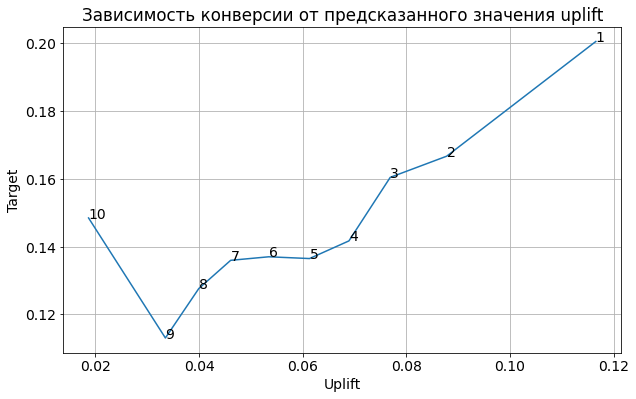

In [25]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,6))

plt.plot(by_deciles['uplift_sm'], by_deciles['target'])
plt.title('Зависимость конверсии от предсказанного значения uplift')
plt.xlabel('Uplift')
plt.ylabel('Target')

for i, j in enumerate(zip(by_deciles['uplift_sm'].values, by_deciles['target'].values)):
    plt.annotate(i+1, xy=(j[0], j[1]))
    
plt.grid()
plt.show()

В целом видим, что более высокое значение конверсии соответствует  
более высоким значениям uplift. Попробую описать своё видение каждого  
участка графика:  
*Дециль 10* - преобладают люди из категории sleeping dogs, которые совершают  
целевое действие при отсутствии коммуникации с нашей стороны.  
*Децили 9-8* - преобладают люди из категории lost causes, не совершающие целевое  
действие, независимо от нашей коммуникации. Модель здесь наиболее уверена в их  
классификации.  
*Децили 7-4* - преобладает комбинация lost causes и sure things. Обе категории не  
реагируют на нашу коммуникацию, среднее значение target зависит только от их соотношения  
в выборке. Модель уже не так уверена, часть людей, вероятно, относится к persuadables.  
*Децили 3-1* - преобладают persuadables, которые наиболее вероятно совершат целевое  
действие только при нашей коммуникации.  
Безусловно, группирование на деле не такое явное, так как модель не идеальна, и в  
каждой нашей группе присутствуют представители всех категорий, но общие тенденции  
должны быть примерно такими.